In [1]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

## 数据集读取

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')


In [3]:
X, y = mnist['data'], mnist['target']
print(type(X),type(y))
print(X.shape, y.shape)
X.iloc[:3,:3],y[:3]

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
(70000, 784) (70000,)


(   pixel1  pixel2  pixel3
 0     0.0     0.0     0.0
 1     0.0     0.0     0.0
 2     0.0     0.0     0.0,
 0    5
 1    0
 2    4
 Name: class, dtype: category
 Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9'])

In [4]:
X, y = X.values, y.values
X[:10,:10],y[:10]
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
# 洗牌
shuffle_index = np.random.permutation(60000)
print(shuffle_index[:10])
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

[12628 37730 39991  8525  8279 51012 14871 15127  9366 33322]


## 交叉验证

In [5]:
# 将十分类转变为二分类
y_train_5 = (y_train=='5')
y_test_5 = (y_test=='5')
y_test_5[:10]

array([False, False, False, False, False, False, False, False,  True,
       False])

In [6]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(max_iter=5, random_state=42)

In [7]:
print(sgd_clf.predict([X[3500]]))
print(y[3500])

[ True]
5


In [8]:
# 用函数直接调用结果进行交叉验证
from sklearn.model_selection import cross_validate
print(cross_validate(sgd_clf, X_train, y_train_5, cv=3, n_jobs=-1, scoring='accuracy')) # scoring是评分方法
print()
print(cross_validate(sgd_clf, X_train, y_train_5, cv=5, n_jobs=-1, scoring='accuracy')) # scoring是评分方法

{'fit_time': array([0.67521906, 0.67321801, 0.67321801]), 'score_time': array([0.0498476 , 0.0498395 , 0.05084038]), 'test_score': array([0.964 , 0.9579, 0.9571])}

{'fit_time': array([1.52542305, 1.33958817, 1.46742105, 1.45673943, 1.48141956]), 'score_time': array([0.05599713, 0.05357599, 0.0510006 , 0.0716939 , 0.05400085]), 'test_score': array([0.96158333, 0.9575    , 0.96166667, 0.9605    , 0.96083333])}


In [9]:
# 自己分组进行交叉验证
from sklearn.model_selection import StratifiedKFold 
from sklearn.base import clone # 克隆 estimator
skflods = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_index, valid_index in skflods.split(X_train, y_train_5):
    X_train_flod = X_train[train_index]
    y_train_flod = y_train[train_index]
    
    X_valid_flod = X_train[valid_index]
    y_valid_flod = y_train[valid_index]

    sgd_clf_flod = clone(sgd_clf)
    sgd_clf_flod.fit(X_train_flod, y_train_flod)
    y_pre_flod = sgd_clf_flod.predict(X_valid_flod)
    
    num_correct = np.sum(y_pre_flod == y_valid_flod)
    print("正确率：", num_correct / len(y_pre_flod))
    # print(len(y_pre_flod), len(y_valid_flod))

正确率： 0.87715
正确率： 0.8723
正确率： 0.8407


In [10]:
# StratifiedGroupKFold 测试
from sklearn.model_selection import StratifiedKFold 
X_ = np.arange(12).reshape((6,2))
y_ = np.array([0, 0, 0, 1, 1, 1])
skflods_ = StratifiedKFold(n_splits=3)
for i,j in skflods_.split(X_, y_):
    print(X_[i], y_[i])
    print(X_[j], y_[j])
    print('---')

[[ 2  3]
 [ 4  5]
 [ 8  9]
 [10 11]] [0 0 1 1]
[[0 1]
 [6 7]] [0 1]
---
[[ 0  1]
 [ 4  5]
 [ 6  7]
 [10 11]] [0 0 1 1]
[[2 3]
 [8 9]] [0 1]
---
[[0 1]
 [2 3]
 [6 7]
 [8 9]] [0 0 1 1]
[[ 4  5]
 [10 11]] [0 1]
---


In [48]:
# 交叉验证 - 返回的是验证集的预测结果 - 由于是训练集每一部分都会被预测，返回的是所有训练集的测试结果
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5, n_jobs=-1)
y_train_pred.shape, X_train.shape

((60000,), (60000, 784))

## 混淆矩阵

In [12]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred) # TN FP \ FN TP

array([[53784,   795],
       [ 1580,  3841]], dtype=int64)

In [13]:
# precision_score and recall_score
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred),recall_score(y_train_5, y_train_pred)

(0.8285159620362381, 0.7085408596199964)

In [14]:
# f1_score - f1_score = 2/(1/precision_score + 1/recall_score)
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7638460773590535

## 阈值对结果的影响

In [92]:
y_scores_ = sgd_clf.decision_function([X[0],X[1],X[2]])  # 传入特征，返回它的得分值
y_pre_ = sgd_clf.predict([X[0],X[1],X[2]])
print(y[[0,1,2]])
y_scores_, y_pre_

['5', '0', '4']
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']


(array([  39607.23825616, -519866.94604343, -662640.07818007]),
 array([ True, False, False]))

In [53]:
# 重新设置阈值计算 confusion_matrix，阈值越高，recall 越小，precision 越大
# 下面展示的是拿 X_train 训练的东西去预测 X_train，不推荐这么做
# 阈值 50000
y_scores_ = sgd_clf.decision_function(X_train)
y_train_pred_50000 = y_scores_ >= 50000 # 把阈值设置为50000，当大于此值时判定为5
print(confusion_matrix(y_train_5, y_train_pred_50000)) # TN FP \ FN TP
print('精度, recall:',precision_score(y_train_5, y_train_pred_50000),recall_score(y_train_5, y_train_pred_50000))

# 阈值 -40000 
y_train_pred_40000 = y_scores_ >= -40000 # 把阈值设置为50000，当大于此值时判定为5
print(confusion_matrix(y_train_5, y_train_pred_40000)) # TN FP \ FN TP
print('精度, recall:',precision_score(y_train_5, y_train_pred_40000),recall_score(y_train_5, y_train_pred_40000))

[[54547    32]
 [ 3489  1932]]
精度, recall: 0.9837067209775967 0.3563918096292197
[[54385   194]
 [ 1839  3582]]
精度, recall: 0.9486228813559322 0.6607636967349197


## precision - recall 曲线

Scikitlearn 不允许直接设置阈值，但是可以得到决策分数(调用decision_function() 方法)，而不是调用predict()，返回分数后在手动设置阈值

In [109]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, n_jobs=-1, method ="decision_function")
y_scores

array([-545086.1906455 , -200238.20632717, -366873.76172794, ...,
       -626454.84454281, -716313.74931348, -581950.04601147])

In [110]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, threholds = precision_recall_curve(y_train_5, y_scores)
threholds.shape, precisions.shape, recalls.shape

((60000,), (60001,), (60001,))

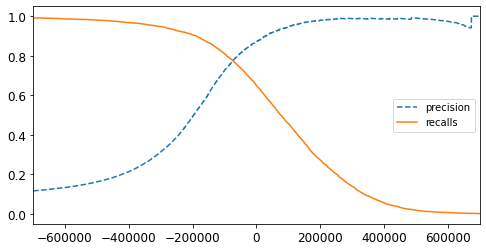

In [111]:
def plot_precision_recall_curve(precisons, recalls, threholds):
    plt.plot(threholds, precisions[:-1], '--', label="precision")
    plt.plot(threholds, recalls[:-1], '-', label="recalls")
    plt.legend()

def plot_precision_vs_recall_curve(precisions, recalls):
    x = range(len(precisions))
    plt.plot(recalls, precisions)
    plt.xlabel('reacall')
    plt.ylabel('precision')
    plt.title('precision_vs_recall')

plt.figure(figsize=(8,4))
plot_precision_recall_curve(precisions, recalls, threholds)
plt.xlim([-700000,700000])
plt.show()

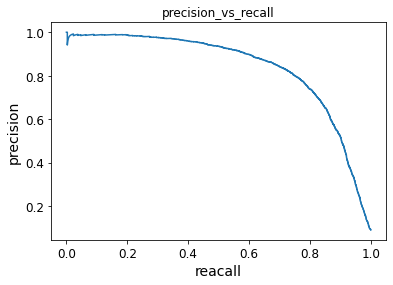

In [112]:
plot_precision_vs_recall_curve(precisions, recalls)

## ROC 曲线

In [115]:
# 通过sklearn绘制roc曲线
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores) # false_positive_rate, ture_positive_rate
fpr.shape, tpr.shape, threholds.shape

((3636,), (3636,), (60000,))

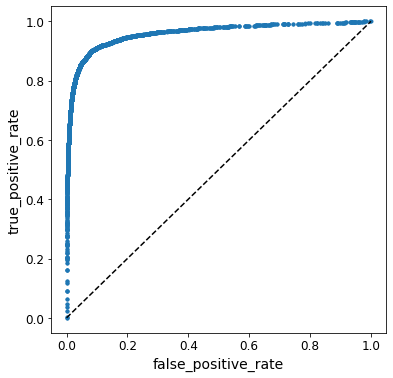

In [116]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, '.', label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('false_positive_rate')
    plt.ylabel('true_positive_rate')
plt.figure(figsize=(6,6))
plot_roc_curve(fpr,tpr)
plt.show()

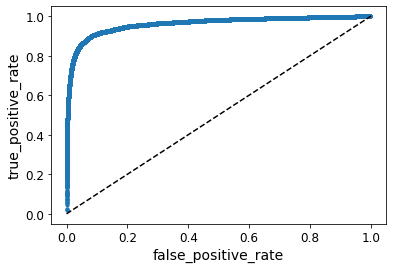

In [120]:
# 通过计算绘制roc曲线 - 下面运行要5min左右
num_is5 = np.sum(y_train_5)
num_not5 = len(y_train_5) - num_is5

fprs,tprs,threholds = [],[],[]
for index,score in enumerate(y_scores[:-1]):
    threhold = (y_scores[index] + y_scores[index+1])/2
    y_pred_each_threhold = (y_scores > threhold)
    cm = confusion_matrix(y_train_5, y_pred_each_threhold)
    fpr,tpr = cm[0,1]/num_not5, cm[1,1]/num_is5
    fprs.append(fpr)
    tprs.append(tpr)
    threholds.append(threhold)
plot_roc_curve(fprs,tprs)